<a href="https://colab.research.google.com/github/BachiLi/redner/blob/master/tutorials/pose_estimation_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial we will use redner to optimize the translational and rotational parameters of an object.

As in the previous tutorial, we will import pyredner_tensorflow and tensorflow, and download the teapot object.

In [1]:
!pip install --upgrade redner-gpu

     |████████████████████████████████| 33.1MB 8.2MB/s 


In [2]:
# Tensorflow by default allocates all GPU memory, leaving very little for rendering.
# We set the environment variable TF_FORCE_GPU_ALLOW_GROWTH to true to enforce on demand
# memory allocation to reduce page faults.
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
%tensorflow_version 2.x
import tensorflow as tf
tf.compat.v1.enable_eager_execution() # redner only supports eager mode
import pyredner_tensorflow as pyredner

TensorFlow 2.x selected.


In [0]:
import urllib
import zipfile
# wget
filedata = urllib.request.urlretrieve('https://casual-effects.com/g3d/data10/common/model/teapot/teapot.zip', 'teapot.zip')
# unzip
zip_ref = zipfile.ZipFile('teapot.zip', 'r')
zip_ref.extractall('teapot/')

In [0]:
objects = pyredner.load_obj('teapot/teapot.obj', return_objects=True)
camera = pyredner.automatic_camera_placement(objects, resolution=(512, 512))

Next, we define a `model` function that takes the objects, camera, and pose parameters, and output an image.

In [0]:
# Obtain the teapot vertices we want to apply the transformation on.
vertices = []
for obj in objects:
    vertices.append(tf.identity(obj.vertices))
# Compute the center of the teapot
center = tf.reduce_mean(tf.concat(vertices, axis=0), axis=0)
def model(translation, euler_angles):
    # Get the rotation matrix from Euler angles
    rotation_matrix = pyredner.gen_rotate_matrix(euler_angles)
    # Shift the vertices to the center, apply rotation matrix,
    # shift back to the original space, then apply the translation.
    for obj, v in zip(objects, vertices):
        obj.vertices = (v - center) @ tf.transpose(rotation_matrix) + center + translation
    # Assemble the 3D scene.
    scene = pyredner.Scene(camera = camera, objects = objects)
    # Render the scene.
    img = pyredner.render_albedo(scene)
    return img

To do pose estimation, we need a target image. In this toy example we use the default pose to render a target image.

In [0]:
target_translation = tf.constant([0.0, 0.0, 0.0])
target_euler_angles = tf.constant([0.0, 0.0, 0.0])

In [7]:
target = model(target_translation, target_euler_angles)

Scene construction, time: 21.59090 s
Forward pass, time: 0.03671 s


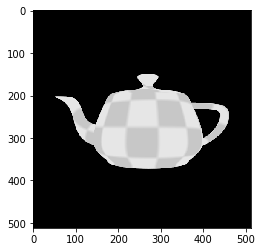

In [8]:
# Visualize target
from matplotlib.pyplot import imshow
%matplotlib inline
# Need to gamma correct the image before display.
imshow(tf.pow(target, 1.0/2.2))

Now we generate the initial guess for the pose estimation.

Scene construction, time: 0.02540 s
Forward pass, time: 0.03679 s


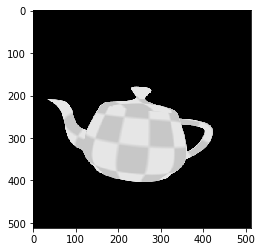

In [9]:
# Set requires_grad=True since we want to optimize them later
translation = tf.Variable([10.0, -10.0, 10.0])
euler_angles = tf.Variable([0.1, -0.1, 0.1])
init = model(translation, euler_angles)
# Visualize the initial guess
imshow(tf.pow(init, 1.0/2.2))

Next, we optimize the pose using Adam. We build two optimizers to have different learning rates for translation and rotation, since they have different dynamic ranges.

In [0]:
t_optimizer = tf.compat.v1.train.AdamOptimizer(0.5)
r_optimizer = tf.compat.v1.train.AdamOptimizer(0.01)

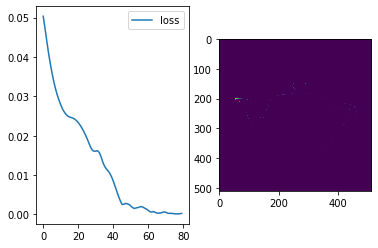

In [11]:
# Setup plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
plt.figure()
imgs, losses = [], []
# Run 80 Adam iterations
num_iters = 80
for t in range(num_iters):
    with tf.GradientTape() as tape:
        img = model(translation, euler_angles)
        # Compute the loss function. Here it is L2.
        loss = tf.reduce_mean(tf.square(img - target))

    grads = tape.gradient(loss, [translation, euler_angles])
    t_optimizer.apply_gradients(zip([grads[0]], [translation]))
    r_optimizer.apply_gradients(zip([grads[1]], [euler_angles]))
    # Plot the loss
    f, (ax_loss, ax_img) = plt.subplots(1, 2)
    losses.append(loss)
    imgs.append(tf.pow(img, 1.0/2.2)) # Record the Gamma corrected image
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_img.imshow(tf.reduce_sum(tf.square(img -target), axis=2))
    plt.show()


We can visualize the intermediate images using matplotlib:

In [0]:
%%capture
from matplotlib import animation
from IPython.display import HTML
fig = plt.figure()
im = plt.imshow(imgs[0], animated=True)
def update_fig(i):
    im.set_array(imgs[i])
    return im,
anim = animation.FuncAnimation(fig, update_fig, frames=len(imgs), interval=50, blit=True)

In [13]:
from IPython.display import HTML
HTML(anim.to_jshtml())